In [1]:
# ==============================
# 1. Import Library
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import shap

# Setup style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

C:\Users\yogib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==============================
# 2. Load Data
# ==============================
# Ganti 'data.csv' dengan nama file datasetmu
df = pd.read_csv("D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P4\dataset_tiktok-scraper_2025-08-21_17-20-12-959.csv")

print("Jumlah baris:", len(df))
print("Kolom yang tersedia:", df.columns.tolist()[:], "...")  # tampilkan sebagian kolom


Jumlah baris: 310
Kolom yang tersedia: ['authorMeta/avatar', 'authorMeta/bioLink', 'authorMeta/commerceUserInfo/category', 'authorMeta/commerceUserInfo/categoryButton', 'authorMeta/commerceUserInfo/commerceUser', 'authorMeta/commerceUserInfo/downLoadLink/android', 'authorMeta/commerceUserInfo/downLoadLink/ios', 'authorMeta/digg', 'authorMeta/fans', 'authorMeta/following', 'authorMeta/friends', 'authorMeta/heart', 'authorMeta/id', 'authorMeta/name', 'authorMeta/nickName', 'authorMeta/originalAvatarUrl', 'authorMeta/privateAccount', 'authorMeta/profileUrl', 'authorMeta/roomId', 'authorMeta/signature', 'authorMeta/ttSeller', 'authorMeta/verified', 'authorMeta/video', 'collectCount', 'commentCount', 'createTime', 'createTimeISO', 'detailedMentions/0/id', 'detailedMentions/0/name', 'detailedMentions/0/nickName', 'detailedMentions/0/profileUrl', 'detailedMentions/1/id', 'detailedMentions/1/name', 'detailedMentions/1/nickName', 'detailedMentions/1/profileUrl', 'detailedMentions/2/id', 'detail

In [3]:
# ==============================
# 1. Ambil kolom penting saja
# ==============================
columns_needed = [
    'authorMeta/fans', 'authorMeta/name', 'collectCount',
    'commentCount', 'createTimeISO', 'diggCount', 'isSponsored',
    'locationMeta/city', 'locationMeta/locationName', 'shareCount',
    'text', 'videoMeta/duration', 'webVideoUrl', 'playCount'
]

df = df[columns_needed].copy()

# ==============================
# 2. Hapus missing values & isi secara kontekstual
# ==============================
# Hapus baris tanpa teks
df.dropna(subset=["text"], inplace=True)

# Isi missing value numerik dengan 0
numeric_cols = ['collectCount', 'commentCount', 'diggCount', 'shareCount', 'playCount', 'authorMeta/fans', 'videoMeta/duration']
df[numeric_cols] = df[numeric_cols].fillna(0)

# Isi missing value string dengan "Unknown"
string_cols = ['authorMeta/name', 'locationMeta/city', 'locationMeta/locationName', 'webVideoUrl']
df[string_cols] = df[string_cols].fillna("Unknown")

# Isi missing value boolean (isSponsored) dengan False
df['isSponsored'] = df['isSponsored'].fillna(False)

# ==============================
# 3. Konversi timestamp ke datetime
# ==============================
df['timestamp'] = pd.to_datetime(df['createTimeISO'], errors='coerce')
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.day_name()

# ==============================
# 4. Buat metrik engagement
# ==============================
# Likes per follower
df['likes_per_follower'] = df['diggCount'] / (df['authorMeta/fans'] + 1)

# Comments per follower
df['comments_per_follower'] = df['commentCount'] / (df['authorMeta/fans'] + 1)

# Comments per like
df['comments_per_like'] = df['commentCount'] / (df['diggCount'] + 1)

# Shares per follower
df['shares_per_follower'] = df['shareCount'] / (df['authorMeta/fans'] + 1)

# Saves per follower
df['saves_per_follower'] = df['collectCount'] / (df['authorMeta/fans'] + 1)

# Views (plays) per follower
df['plays_per_follower'] = df['playCount'] / (df['authorMeta/fans'] + 1)

# Total engagement per follower (likes + comments + shares + saves)
df['total_engagement_per_follower'] = (
    df['diggCount'] + df['commentCount'] + df['shareCount'] + df['collectCount']
) / (df['authorMeta/fans'] + 1)

# Engagement rate (%) = total engagement dibagi views
df['engagement_rate'] = (
    df['diggCount'] + df['commentCount'] + df['shareCount'] + df['collectCount']
) / (df['playCount'] + 1) * 100

# ==============================
# 5. Tampilkan 5 baris pertama
# ==============================
df.head(50)


C:\Users\yogib\AppData\Local\Temp\ipykernel_2088\975527102.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isSponsored'] = df['isSponsored'].fillna(False)


,authorMeta/fans,authorMeta/name,collectCount,commentCount,createTimeISO,diggCount,isSponsored,locationMeta/city,locationMeta/locationName,shareCount,...,hour,dayofweek,likes_per_follower,comments_per_follower,comments_per_like,shares_per_follower,saves_per_follower,plays_per_follower,total_engagement_per_follower,engagement_rate
1,42.0,bettagardens,2.0,0.0,2025-06-23T23:13:22.000Z,4.0,False,Unknown,Unknown,0.0,...,23,Monday,0.093023,0.000000,0.000000,0.000000,0.046512,2.906977,0.139535,4.761905
2,42.0,bettagardens,3.0,0.0,2025-08-04T22:48:33.000Z,5.0,False,Unknown,Unknown,3.0,...,22,Monday,0.116279,0.000000,0.000000,0.069767,0.069767,3.069767,0.255814,8.270677
3,413.0,bettagardenn,0.0,0.0,2025-06-11T03:23:15.000Z,29.0,False,Rejang Lebong Regency,SETIA NEGARA CITY PARK,0.0,...,3,Wednesday,0.070048,0.000000,0.000000,0.000000,0.000000,0.408213,0.070048,17.058824
4,413.0,bettagardenn,0.0,3.0,2024-11-28T02:13:35.000Z,27.0,False,Unknown,Rejang Lebong Regency,1.0,...,2,Thursday,0.065217,0.007246,0.107143,0.002415,0.000000,0.707729,0.074879,10.544218
5,413.0,bettagardenn,1.0,3.0,2025-05-23T03:01:04.000Z,31.0,False,Rejang Lebong Regency,SETIA NEGARA CITY PARK,0.0,...,3,Friday,0.074879,0.007246,0.093750,0.000000,0.002415,0.495169,0.084541,16.990291
6,802.0,bettas.garden,3.0,1.0,2025-06-29T13:52:38.000Z,36.0,False,Unknown,Unknown,0.0,...,13,Sunday,0.044832,0.001245,0.027027,0.000000,0.003736,1.622665,0.049813,3.067485
7,413.0,bettagardenn,0.0,0.0,2025-07-19T03:52:05.000Z,10.0,False,Unknown,Unknown,0.0,...,3,Saturday,0.024155,0.000000,0.000000,0.000000,0.000000,0.374396,0.024155,6.410256
8,413.0,bettagardenn,0.0,0.0,2025-07-14T09:43:33.000Z,22.0,False,Unknown,Unknown,0.0,...,9,Monday,0.053140,0.000000,0.000000,0.000000,0.000000,0.618357,0.053140,8.560311
10,42.0,bettagardens,2.0,0.0,2025-07-07T22:44:33.000Z,4.0,False,Unknown,Unknown,0.0,...,22,Monday,0.093023,0.000000,0.000000,0.000000,0.046512,3.209302,0.139535,4.316547
11,802.0,bettas.garden,114.0,30.0,2025-07-30T20:33:42.000Z,879.0,False,Unknown,Unknown,42.0,...,20,Wednesday,1.094645,0.037360,0.034091,0.052304,0.141968,32.752179,1.326276,4.049276


C:\Users\yogib\AppData\Local\Temp\ipykernel_2088\3449643156.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='total_engagement_per_follower', data=hourly_engagement, palette='viridis')


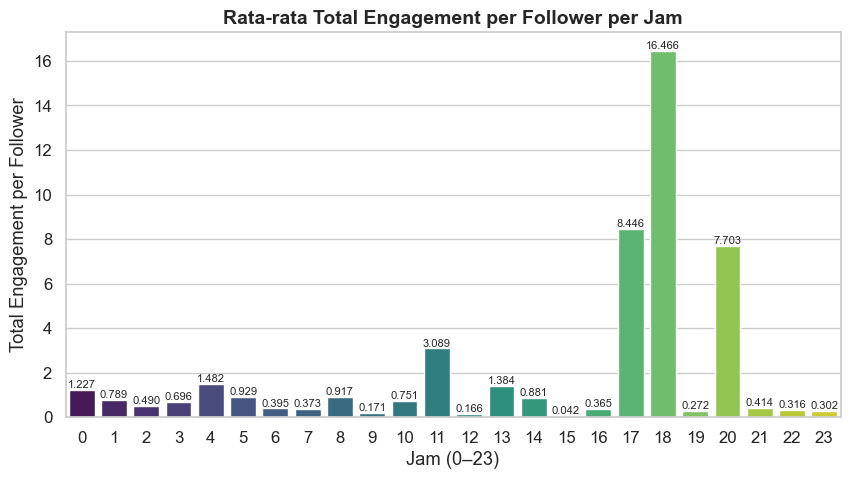

C:\Users\yogib\AppData\Local\Temp\ipykernel_2088\3449643156.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dayofweek', y='total_engagement_per_follower', data=daily_engagement, palette='magma')


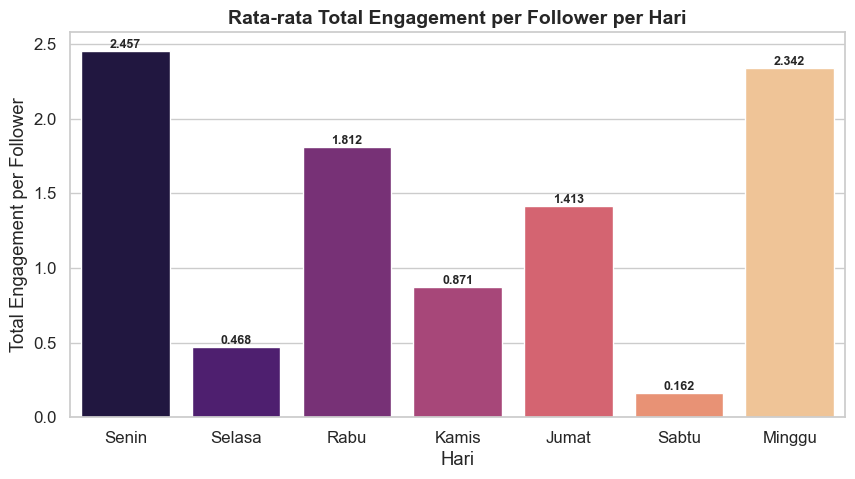

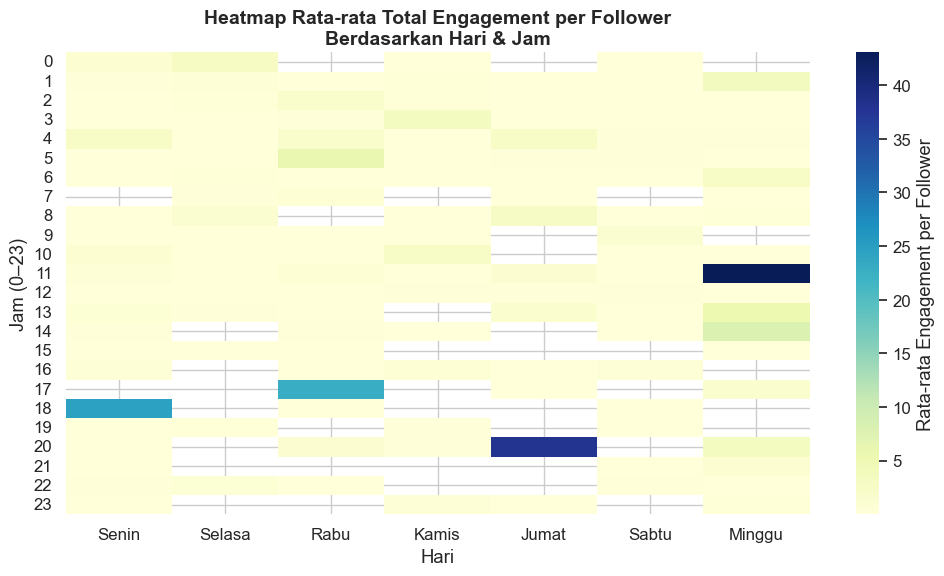

In [4]:


# ==============================
# 1. Engagement rata-rata per jam
# ==============================
hourly_engagement = df.groupby('hour')['total_engagement_per_follower'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='hour', y='total_engagement_per_follower', data=hourly_engagement, palette='viridis')

# Tambahkan angka di atas bar
for i, v in enumerate(hourly_engagement['total_engagement_per_follower']):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

plt.title('Rata-rata Total Engagement per Follower per Jam', fontsize=14, weight="bold")
plt.xlabel('Jam (0–23)')
plt.ylabel('Total Engagement per Follower')
plt.xticks(range(0,24))
plt.show()

# ==============================
# 2. Engagement rata-rata per hari
# ==============================
days_order_en = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order_id = ['Senin','Selasa','Rabu','Kamis','Jumat','Sabtu','Minggu']

daily_engagement = (
    df.groupby('dayofweek')['total_engagement_per_follower']
    .mean()
    .reindex(days_order_en)
    .reset_index()
)
daily_engagement['dayofweek'] = days_order_id  # Mapping ke Bahasa Indonesia

plt.figure(figsize=(10,5))
sns.barplot(x='dayofweek', y='total_engagement_per_follower', data=daily_engagement, palette='magma')

# Tambahkan angka di atas bar
for i, v in enumerate(daily_engagement['total_engagement_per_follower']):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.title('Rata-rata Total Engagement per Follower per Hari', fontsize=14, weight="bold")
plt.xlabel('Hari')
plt.ylabel('Total Engagement per Follower')
plt.show()

# ==============================
# 3. Heatmap Engagement per Hari vs Jam
# ==============================
heatmap_data = df.pivot_table(
    index="hour",
    columns="dayofweek",
    values="total_engagement_per_follower",
    aggfunc="mean"
)

# Urutkan kolom hari (Senin → Minggu)
heatmap_data = heatmap_data[days_order_en]
heatmap_data.columns = days_order_id  # ubah ke bahasa Indonesia

plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=False,
    cbar_kws={'label': 'Rata-rata Engagement per Follower'}
)

plt.title("Heatmap Rata-rata Total Engagement per Follower\nBerdasarkan Hari & Jam", fontsize=14, weight="bold")
plt.xlabel("Hari")
plt.ylabel("Jam (0–23)")
plt.yticks(rotation=0)
plt.show()


=== Model Performance ===
MAE : 0.5873
R²  : 0.7766
Cross-Validation R² Scores: [0.96016845 0.89917335 0.99134266 0.56420166 0.89529153]
Mean CV R²: 0.8620


C:\Users\yogib\AppData\Local\Temp\ipykernel_2088\2072693951.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances_df, palette="viridis")


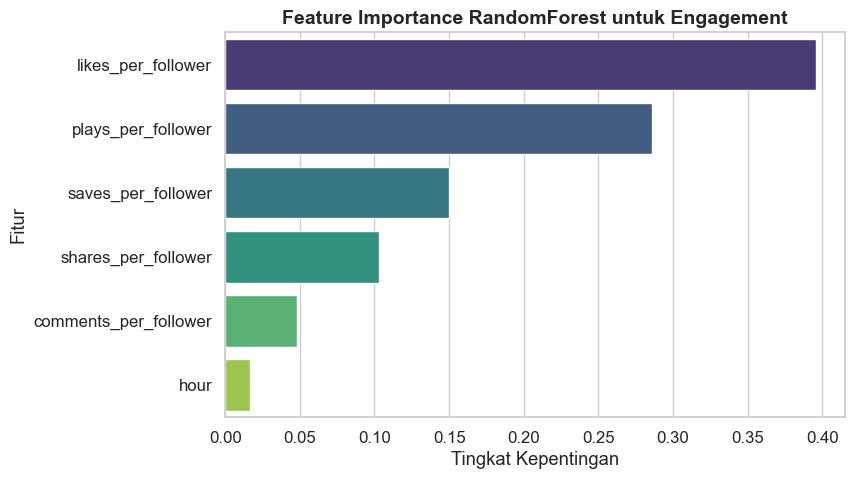


=== Feature Importance ===
                 Feature  Importance
0     likes_per_follower    0.395662
4     plays_per_follower    0.286194
3     saves_per_follower    0.149998
2    shares_per_follower    0.102977
1  comments_per_follower    0.048363
5                   hour    0.016806


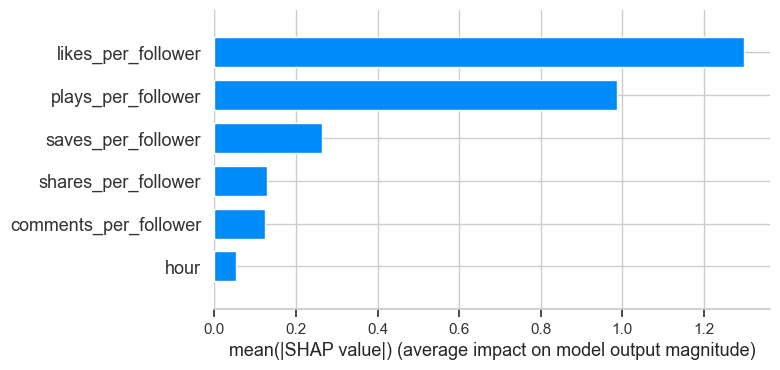

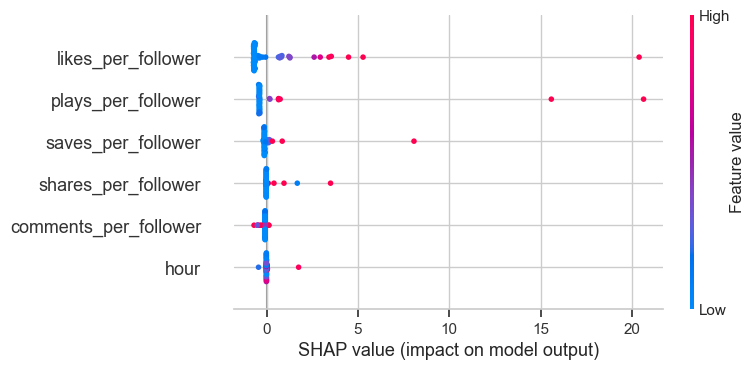


 (X_test.iloc[0]):
 likes_per_follower        1.725365
comments_per_follower     0.006678
shares_per_follower       0.087183
saves_per_follower        0.091624
plays_per_follower       37.286872
hour                      2.000000
Name: 184, dtype: float64


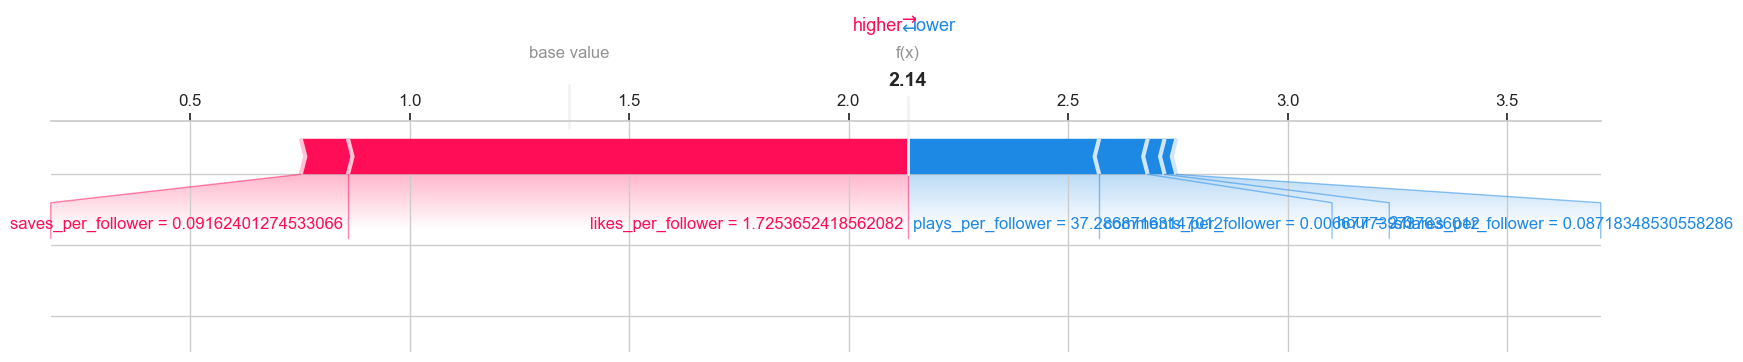

In [5]:
# ==============================
# 1. Ambil kolom penting
# ==============================
columns_needed = [
    'authorMeta/fans', 'authorMeta/name', 'collectCount',
    'commentCount', 'createTimeISO', 'diggCount', 'isSponsored',
    'locationMeta/city', 'locationMeta/locationName', 'shareCount',
    'text', 'videoMeta/duration', 'webVideoUrl', 'playCount'
]

df = df[columns_needed].copy()

# ==============================
# 2. Hapus missing values & isi kontekstual
# ==============================
df.dropna(subset=["text"], inplace=True)

numeric_cols = [
    'collectCount', 'commentCount', 'diggCount',
    'shareCount', 'playCount', 'authorMeta/fans', 'videoMeta/duration'
]
df[numeric_cols] = df[numeric_cols].fillna(0)

string_cols = [
    'authorMeta/name', 'locationMeta/city',
    'locationMeta/locationName', 'webVideoUrl'
]
df[string_cols] = df[string_cols].fillna("Unknown")

df['isSponsored'] = df['isSponsored'].fillna(False)

# ==============================
# 3. Konversi timestamp
# ==============================
df['timestamp'] = pd.to_datetime(df['createTimeISO'], errors='coerce')
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.day_name()

# ==============================
# 4. Feature Engineering (Engagement Metrics)
# ==============================
df['likes_per_follower']    = df['diggCount'] / (df['authorMeta/fans'] + 1)
df['comments_per_follower'] = df['commentCount'] / (df['authorMeta/fans'] + 1)
df['comments_per_like']     = df['commentCount'] / (df['diggCount'] + 1)
df['shares_per_follower']   = df['shareCount'] / (df['authorMeta/fans'] + 1)
df['saves_per_follower']    = df['collectCount'] / (df['authorMeta/fans'] + 1)
df['plays_per_follower']    = df['playCount'] / (df['authorMeta/fans'] + 1)

df['total_engagement_per_follower'] = (
    df['diggCount'] + df['commentCount'] + df['shareCount'] + df['collectCount']
) / (df['authorMeta/fans'] + 1)

df['engagement_rate'] = (
    df['diggCount'] + df['commentCount'] + df['shareCount'] + df['collectCount']
) / (df['playCount'] + 1) * 100

# ==============================
# 5. Siapkan Feature & Target
# ==============================
features = [
    "likes_per_follower", "comments_per_follower",
    "shares_per_follower", "saves_per_follower",
    "plays_per_follower", "hour"
]
X = df[features]
y = df["total_engagement_per_follower"]

# ==============================
# 6. Split Data
# ==============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# 7. Train Model (Random Forest)
# ==============================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ==============================
# 8. Evaluation
# ==============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Model Performance ===")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

cv_scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")

# ==============================
# 9. Feature Importance
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = model.feature_importances_
importances_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=importances_df, palette="viridis")
plt.title("Feature Importance RandomForest untuk Engagement", fontsize=14, weight="bold")
plt.xlabel("Tingkat Kepentingan")
plt.ylabel("Fitur")
plt.show()

print("\n=== Feature Importance ===")
print(importances_df)

# ==============================
# 10. SHAP Analysis
# ==============================
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# (a) SHAP Summary (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# (b) SHAP Beeswarm
shap.summary_plot(shap_values, X_test)

# (c) SHAP Force plot untuk 1 data
idx = 0
print("\n (X_test.iloc[0]):\n", X_test.iloc[idx])
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], matplotlib=True)


In [6]:
import joblib

# ============================
# 9. Save & Load Model
# ============================

# Simpan model
joblib.dump(model, "tiktok_engagement_model.pkl")
print("✅ Model berhasil disimpan sebagai 'tiktok_engagement_model.pkl'")

✅ Model berhasil disimpan sebagai 'tiktok_engagement_model.pkl'
